In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: may have to add '..' if move from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot.util import *

import matplotlib.pyplot as plt 
import numpy as np 
from pprint import pprint as pp 
import pandas as pd

# Tab after '.' to get all methods 
# Tab Shift after () to get documentation.
# To read excel data:
# pd.read_excel('afn_infil_data.xlsx')

In [3]:
_df = pd.read_excel('afn_infil_data.xlsx')
_df['afn_infil'] *= 1.225 # kg/m3
_df['ifrea_infil'] *= 1.225 # kg/m3
#df['afn_infil'] *= 85 # kg/m3
#df['ifrea_infil'] *= 85 # kg/m3

_df.head()

,ifrea_infil,afn_infil,mean_dpa,Unnamed: 3,pa,infil
0,0.000751,0.000137,0.182452,NaN,4.0000,0.000085
1,0.000737,0.000125,0.153641,NaN,2.0000,0.000133
2,0.000737,0.000129,0.159005,NaN,1.0000,0.000208
3,0.000737,0.000127,0.156621,NaN,0.1717,0.000651
4,0.000737,0.000125,0.148678,NaN,NaN,NaN


In [10]:
def refdp_formula(target_infil, out_infil, in_dpa):
    """Returns refdp via derived formula."""
    n = 0.65 
    target_infil *= 1.225 
    out_infil *= 1.225 
    return ((out_infil / target_infil) ** (1/n)) * in_dpa

def refdp_lm(out_infil, in_dpa):
    """Returns solved function for refdp, based on data samples."""
    
    def by_formula(_out_infil, _in_dpa):
        """Return refdp_formula with solved constants."""
        def _by_formula(_target_infil):
            return refdp_formula(_target_infil, _out_infil, _in_dpa)
        return _by_formula
    
     def by_lm(_B):
         """Return linear predictor."""
         def _by_lm(x): 
             x = np.array([np.log(np.array(x) * 1.225), np.ones_like(x)]).T
             return np.exp(x @ _B)
         return _by_lm 

    if len(out_infil) == 1 or len(in_dpa) == 1:
        return by_formula(out_infil[0], in_dpa[0]) 

    log_out_infil = np.log(out_infil * 1.225)     
    log_in_dpa = np.log(in_dpa)

    X = np.array([log_out_infil, np.ones_like(log_out_infil)]).T 
    y = log_in_dpa
    B = np.linalg.pinv(X.T @ X) @ X.T @ y
    
    return by_lm(B) 

# Samples from simulation 
out_infil = np.array([0.000085, 0.000133])
in_dpa = np.array([4, 2])
target_infil = 0.000569 # m3/m2-s

refdp1 = refdp_formula(target_infil, out_infil[0], in_dpa[0])
refdp2 = refdp_lm(out_infil[0:1], in_dpa[0:1])(target_infil)
refdp3 = refdp_lm(out_infil, in_dpa)(target_infil)


print(refdp1, refdp2, refdp3)
# >> 0.21466564422720613 0.21466564422720613 0.21070857593050055


0.21466564422720613 0.21466564422720613 0.21070857593050055


In [291]:
#df = _df
"""
Find Pact that produces target_minfil by fitting line to two data points.
    
# Convert to log space
m = C * P^n  
log_m = log_C + n * log_P

# To solve for log_P_act, given some target log_m_act 
# we can rearrange orifice eqn: 
log_m_act = log_C + n * log_P_act 
log_P_act = (log_m_act - log_C) / n (1)

# log_C is unknown, but can solved using log_P_ref 
log_C = (log_m_ref - n * log_P_ref) (2)

# Substitute (2) into (1)
log_P_act = (log_m_act - (log_m_ref - n * log_P_ref)) / n 

# In f(x) = mx + b form:
log_P_act(log_m_act) = (1 / n) * log_m_act - (log_m_ref - n * log_P_ref) / n

# So log_P_act is a linear function of m_act, with slope of 1 / n, 
# and bias of (log_m_ref - n * log_P_ref) / n.   

# If we substitute a target m_act=0.00056 then we can find P_act, 
# assuming we have a reference datapoint of (m, P). 
# However, in actuality, the dataset is noisy so we need to use multiple 
# data points to ensure we can fit a line robust to noise. Fitting a line 
# works perfectly, because as described above, the underlying relationship 
# btwn our variables is linear.   

There are two unknowns: log_C/n and 1/n. So at minimum to can solve 
this problem with two datapoints, (which is equivalent to just fitting 
the data to a line) which in practise is surprisingly 
accurate, but for more complex problems it's best to use at least three 
points. 
"""

df = pd.DataFrame(
    {
        'afn_infil': np.array([0.000085, 0.000133]) * 1.225,
        'mean_dpa': [4, 2]
    }
)

# df = pd.DataFrame(
#     {
#         'afn_infil': np.array([0.000022, 0.000034]) * 1.225,
#         'mean_dpa': [4, 2]
#     }
# )



def gx(tarm, refm, refP):
    # log_P_act = (1 / n) * log_m_act - (log_m_ref - n * log_P_ref) / n
    
    tarm *= 1.225  
    log_refm, log_refP = np.log(refm), np.log(refP)
    log_tarm = np.log(tarm) # makes negative 
    
    dm = log_refm[0] - log_refm[1]
    dP = log_refP[0] - log_refP[1]
    slope_n = dm / dP  # = 1 / n # slope is always neg since m/p opposite
    #print(slope_n)
    #log_C0 = np.log(refm[1]) - (slope_n * np.log(refP[1]))
    #print('C', log_C0)

    #_, ax = plt.subplots()
    log_refm = np.array(list(log_refm) + [log_tarm])
    log_refP = np.array(list(log_refP) + [np.log(0.21)])
    ref_idx = np.array([0, 1])
 
    # Trying to get n working...
    n = 0.65
    B1 = - 1 / n 
    B0 = (log_refm[[0, 1]] / n) + log_refP[[0, 1]] 
    # Solve for P_default w/ one sim
    log_P = (B1 * log_refm[ref_idx]) + B0
    #print(np.exp(log_P))
    tar_log_P = (B1 * log_tarm) + B0
    #P = np.exp(tar_log_P)
    
    P = ((refm[[0]] / tarm) ** (1/n)) * refP[[0]]
    P = P.values
    print(refm[0], tarm, refP[0], n)
    tar_log_P = np.log(P)[0]

    #ax.plot(log_refm[ref_idx], log_P, marker='o', c='green')
    #ax.set_xlabel('ref_m'); ax.set_ylabel('P'); ax.grid()
    #ax.set_xlim([-10, 0])
    #ax.plot
    #ax.scatter(log_tarm, np.log(0.21), s=200, c='red', alpha=0.5)
    #ax.scatter(log_tarm, tar_log_P, s=50, c='brown')
    
    return P 


gx(0.000569, df.afn_infil, df.mean_dpa)
# 0.21070857593050055
# 0.022525068280737356


0.00010412500000000001 0.000697025 4 0.65


array([0.21466564])

Text(0, 0.5, 'infil [m3/s]')

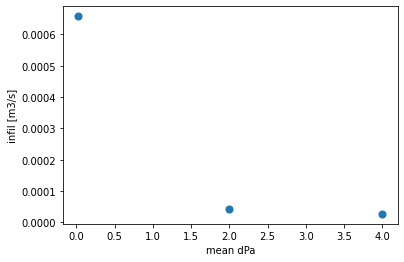

In [144]:
# Plot + dP against afn_infil
# + dPa indicates air coming into zone 

f, a, = plt.subplots(1, 1)
a.scatter(df.mean_dpa, df.afn_infil, s=50)
a.set_xlabel('mean dPa')
a.set_ylabel('infil [m3/s]')

# This is a very noisy version of what we expect, 
# logarithmic increase in infiltration with 
# increase in Pa difference. But data is noisy 
# due to impact of multiple walls, openings. 

Text(0, 0.5, 'log infil [m3/s]')

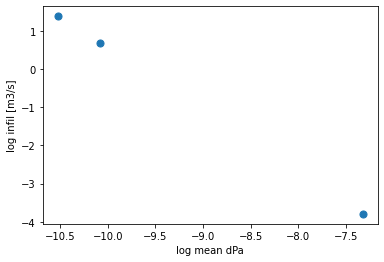

In [145]:
# Linearize data

log_afn_infil = np.log(df.afn_infil)  # X
log_mean_dpa = np.log(df.mean_dpa)  # y

f, a, = plt.subplots(1, 1)
a.scatter(log_afn_infil, log_mean_dpa, s=50)
a.set_xlabel('log mean dPa')
a.set_ylabel('log infil [m3/s]')


In [146]:
# Create regression model
# add 1s row so that we have a bias
# X: 2, 2915
# y: 1, 2915 
X = np.array(
    [log_afn_infil,
    np.ones_like(log_afn_infil)]) 
y = log_mean_dpa


# 1. Projection matrix 
X = X.T  # 2915, 2
P = X @ np.linalg.pinv(X.T @ X) @ X.T
print('Proj matrix', P.shape)  # 2915, 2915 

# Project y onto X plane 
yhat1 = P @ y

# 2. Weights matrix 
B = np.linalg.pinv(X.T @ X) @ X.T @ y
print('Weights matrix', B.shape)  # (2, )
yhat2 = X @ B 

assert np.sum(yhat1 - yhat2) < 1e-10


Proj matrix (3, 3)
Weights matrix (2,)


In [147]:
# Extract weights from Beta matrix 
print(B) # B0~n, B1~Cw

# print(np.exp(np.log(8)).round(2))  # confirm log = ln

# ln_m = n * ln_P + ln_C 
# ln_P = ln_m/n - ln_C/n
# B0=1/n, B1=ln_C/n  

n = 1 / B[0]  # ~ 0.65
log_Cw = np.exp(B[1]/B[0]) # ~ 0.00001
print('Cw:', log_Cw.round(4))
print('n: ', n.round(4))

# n, flow exponent is perfect 
# Cw, flow coefficient is way to high

[ -1.62274588 -15.68132371]
Cw: 15731.9672
n:  -0.6162


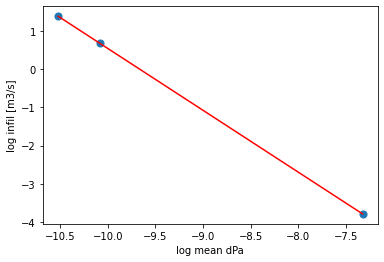

In [148]:
f, a, = plt.subplots(1, 1)
a.scatter(log_afn_infil, log_mean_dpa, s=50)
a.set_xlabel('log mean dPa')
a.set_ylabel('log infil [m3/s]')

# Plot regression line, looks reasonable  
a.plot(log_afn_infil, yhat2, 'red')

0.02052548151548061

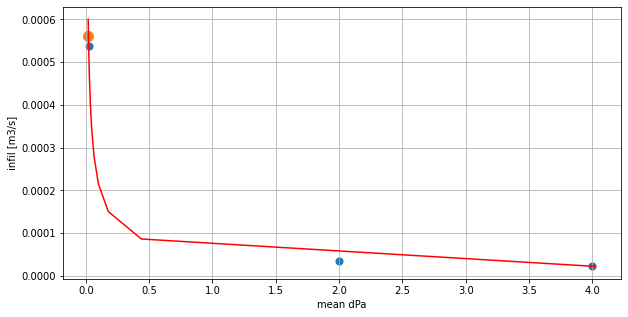

In [149]:
# test what we get for minfil=0.00056 * 1.225
def fx(_m):
    _m *= 1.225
    return np.exp((B[0] * np.log(_m)) + B[1])

f, a, = plt.subplots(1, 1, figsize=(10, 5))
a.scatter(df.mean_dpa, df.afn_infil / 1.225, s=50)
a.set_xlabel('mean dPa')
a.set_ylabel('infil [m3/s]')
#a.set_xticks(np.linspace(0, 0.00035, 10))
#a.set_yticks(np.linspace(0, 0.7, 15))
a.grid() 

fake_infil = np.linspace(np.min(df.afn_infil) / 1.225, 0.0006, 10)
a.plot([fx(i) for i in fake_infil], fake_infil, 'red')
a.scatter([fx(0.00056)], [0.00056], s=100)

fx(0.000569)  # target infil 
# >> 1.3608891 != 0.17